### Dans cette partie, nous allons réaliser une segmentation des différents postes et essayer de comprendres autres subtilités que l'analyse exploratoire n'a pas permis de vite percevoir

In [44]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [27]:
df = pd.read_parquet("data/df_segmentation.parquet")
df.head()

,likes,comments,shares,theme,followers,text_length,day_of_week,time_of_day,nbr_hashtags,is_viral,engagement_category
0,25,21,0,IA,15414,318,4.0,Fin de journée,2,False,Faible
1,5,0,0,IA,471,43,4.0,Soir,15,False,Faible
2,0,0,0,IA,0,6,5.0,Soir,5,False,Faible
3,0,0,0,IA,15929,1,5.0,Soir,0,False,Faible
4,0,0,0,IA,0,17,5.0,Tôt le matin,4,False,Faible


In [28]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
likes,1842.0,38.349620,70.717072,0.0,3.00,15.5,43.00,834.0
comments,1842.0,12.483170,22.681269,0.0,0.00,4.0,16.00,261.0
shares,1842.0,7.798046,22.114374,0.0,0.00,1.0,6.00,346.0
followers,1842.0,1026.053203,14802.419890,0.0,0.00,0.0,51.75,586005.0
text_length,1842.0,169.398480,109.168253,1.0,89.25,157.0,233.75,524.0
day_of_week,1750.0,4.321143,1.084618,1.0,4.00,4.0,5.00,7.0
nbr_hashtags,1842.0,7.172096,13.653436,0.0,0.00,4.0,8.00,173.0


In [29]:
df.describe(include=["O", "bool"]).transpose()

,count,unique,top,freq
theme,1842,10,Leadership,299
time_of_day,1750,5,Après-midi,675
is_viral,1842,2,False,1651
engagement_category,1842,2,Faible,1656


In [5]:
# Select numeric columns in the Polars DataFrame
numeric_columns = [col for col, dtype in zip(df.columns, df.dtypes) if dtype in [pl.Int64, pl.Float64, pl.Int8, pl.Float32]]
df_numeric = df.select(numeric_columns)
df_numeric.head()

likes,comments,shares,followers,day_of_week,hour,nbr_hashtags
i64,i64,i64,i64,i8,i8,i64
25,21,0,15414,4,19,2
5,0,0,471,4,21,15
0,0,0,0,5,4,5
0,0,0,15929,5,3,0
0,0,0,0,5,8,4


In [32]:
df_numeric = df.select_dtypes("number").drop(["day_of_week"], axis=1)

Text(0.5, 1.0, 'Correlations')

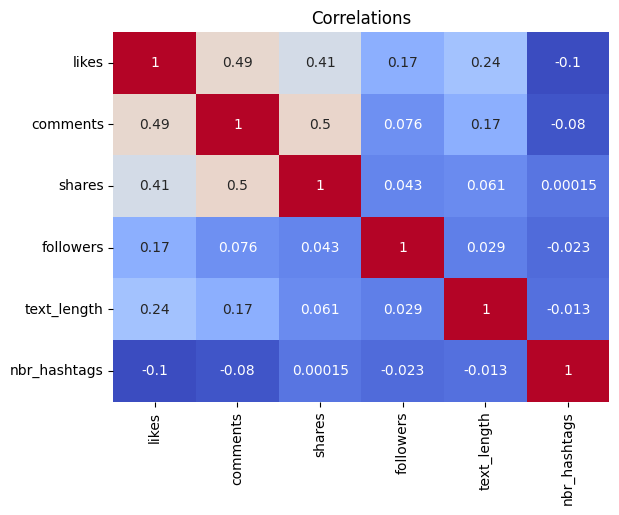

In [35]:
sns.heatmap(df_numeric.corr(), annot=True, cbar=False, cmap="coolwarm");
plt.title("Correlations")

- Les interactions (likes, commentaires, partages) sont liées entre elles ➔ Quand un post est bon, il cartonne sur tous les indicateurs à la fois.

- Le nombre de followers est un facteur faible ➔ Ce n’est pas le nombre de followers qui garantit de l'engagement, c'est la qualité du contenu !

- Les posts un peu plus longs performent légèrement mieux ➔ N'hésite pas à développer un peu ton texte (mais reste concis et pertinent).

- Trop de hashtags n’aide pas ➔ Utilise-les avec stratégie, pas en quantité.

### Encodage des variables catégorielles

In [37]:
df_encoded = pd.get_dummies(df, columns=['theme', 'day_of_week', 'time_of_day', 'engagement_category'], drop_first=True).astype(int)
df_encoded["is_viral"] = df_encoded["is_viral"].astype(int)
df_encoded.head()

,likes,comments,shares,followers,text_length,nbr_hashtags,is_viral,theme_HumanResources,theme_IA,theme_Leadership,...,day_of_week_3.0,day_of_week_4.0,day_of_week_5.0,day_of_week_6.0,day_of_week_7.0,time_of_day_Fin de journée,time_of_day_Milieu de matinée,time_of_day_Soir,time_of_day_Tôt le matin,engagement_category_Fort
0,25,21,0,15414,318,2,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0
1,5,0,0,471,43,15,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
2,0,0,0,0,6,5,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
3,0,0,0,15929,1,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
4,0,0,0,0,17,4,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0


### Normalisation des données

In [38]:
from sklearn.preprocessing import StandardScaler

In [39]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_encoded)

📚 DBSCAN — Pour la segmentation
- DBSCAN = Density-Based Spatial Clustering of Applications with Noise

In [49]:
df_encoded.shape

(1842, 27)

In [50]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

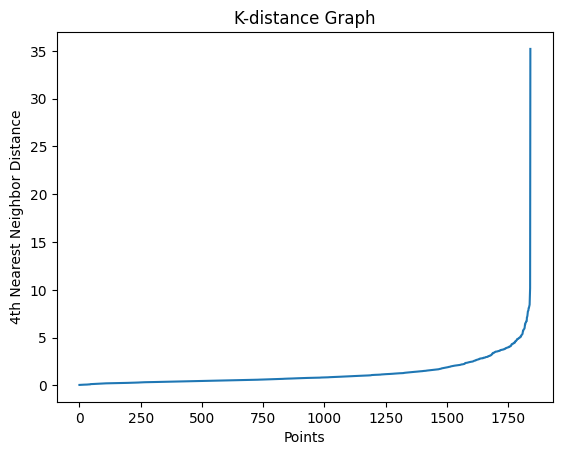

In [51]:
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(df_scaled)
distances, indices = neighbors_fit.kneighbors(df_scaled)

distances = np.sort(distances[:, 4], axis=0)
plt.plot(distances)
plt.title('K-distance Graph')
plt.xlabel('Points')
plt.ylabel('4th Nearest Neighbor Distance')
plt.show()


- Choisissons donc un eps proche de 5 soit: 4.5
- min_samples: 28

In [52]:
dbscan = DBSCAN(eps=4.5, min_samples=28)
labels = dbscan.fit_predict(df_scaled)

In [53]:
df["cluster"] = labels
df["cluster"].value_counts()

cluster
 0    1576
-1      85
 1      58
 4      43
 2      43
 3      37
Name: count, dtype: int64

### Visualisation des clusters

In [67]:
from sklearn.manifold import TSNE

In [68]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(df_scaled)

In [69]:
df_viz_tsne = pd.DataFrame(X_tsne, columns=['Dim1', 'Dim2'])
df_viz_tsne['cluster'] = labels

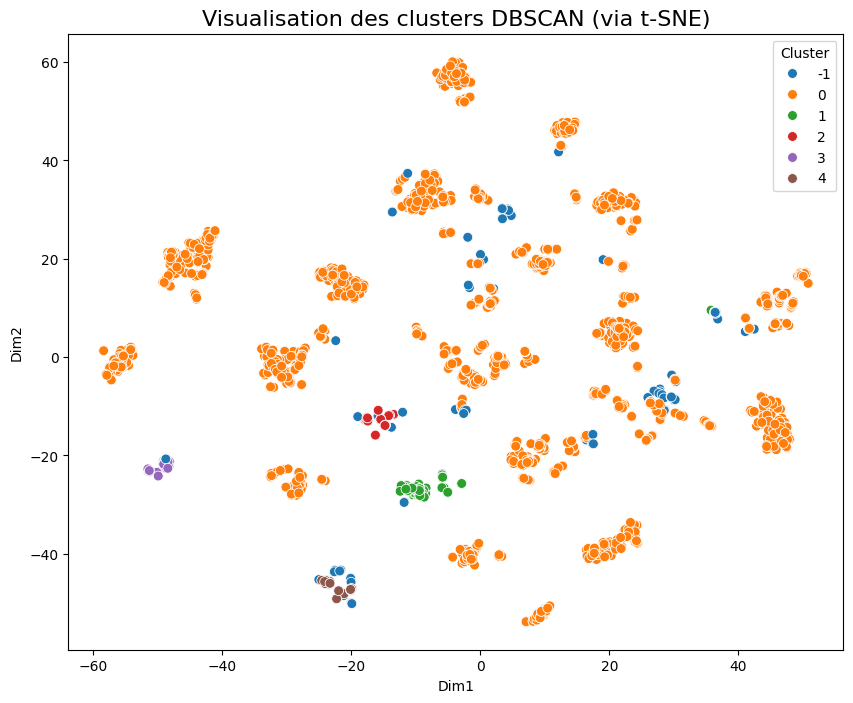

In [70]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_viz_tsne, x='Dim1', y='Dim2', hue='cluster', palette='tab10', s=50)
plt.title('Visualisation des clusters DBSCAN (via t-SNE)', fontsize=16)
plt.legend(title='Cluster')
plt.show()


In [72]:
df["cluster"].value_counts()

cluster
 0    1576
-1      85
 1      58
 4      43
 2      43
 3      37
Name: count, dtype: int64

In [102]:
cluster_num = -1
cluster_df = df[df["cluster"] == cluster_num]
cluster_df.head()

,likes,comments,shares,theme,followers,text_length,day_of_week,time_of_day,nbr_hashtags,is_viral,engagement_category,cluster
11,3,0,1,IA,125396,305,4.0,Soir,0,False,Faible,-1
13,279,77,4,IA,0,121,4.0,Soir,0,False,Fort,-1
53,145,261,2,IA,0,259,4.0,Fin de journée,0,False,Fort,-1
54,137,19,21,IA,0,205,5.0,Soir,0,True,Fort,-1
71,766,24,56,IA,0,45,4.0,Soir,0,True,Fort,-1


In [99]:
cluster_df.shape, df.shape

((43, 12), (1842, 12))

In [103]:
cluster_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
likes,85.0,194.505882,201.556067,0.0,31.0,137.0,279.0,834.0
comments,85.0,55.623529,61.936407,0.0,8.0,30.0,83.0,261.0
shares,85.0,45.470588,73.925894,0.0,2.0,17.0,50.0,346.0
followers,85.0,12299.352941,66680.108534,0.0,0.0,28.0,59.0,586005.0
text_length,85.0,202.294118,114.897037,15.0,106.0,189.0,277.0,515.0
day_of_week,83.0,3.939759,1.291146,2.0,3.0,4.0,5.0,7.0
nbr_hashtags,85.0,17.882353,36.767420,0.0,0.0,4.0,11.0,173.0
cluster,85.0,-1.000000,0.000000,-1.0,-1.0,-1.0,-1.0,-1.0


In [104]:
cluster_df.describe(include=["O", "bool"]).transpose()

,count,unique,top,freq
theme,85,10,WorkplaceCulture,20
time_of_day,83,5,Après-midi,31
is_viral,85,2,False,45
engagement_category,85,2,Fort,58


In [106]:
df.to_parquet("data/df_clusters.parquet")